# 1. Introduccion
### En este cuaderno vamos a practicar haciendo dos redes neuronales convolucionales a un dataset de imágenes:
* https://www.kaggle.com/datasets/imsparsh/flowers-dataset/data (clasificación multiclase)
### Este dataset como veremos a continuación, contiene ejemplos de imágenes divididos en 5 tipos de flores:
* daisy (margarita)
* dandelio (diente de leon)
* rose (rosa)
* sunflower (girasol)
* tulip (tulipan)
### y nuestro deber será intentar crear un modelo que nos ayude a diferenciar entre clases.

# 2. Clasificación Multiclase (5 tipos de flores)

## 2.1 Importamos el dataset

In [44]:
import os
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Descargar el dataset
import kagglehub
path = kagglehub.dataset_download("imsparsh/flowers-dataset")
print("Path to dataset files:", path)

# Definir las rutas de las carpetas
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

# Cargar imágenes de entrenamiento y asignar etiquetas
train_images = []
train_labels = []

for class_name in os.listdir(train_dir):  # Recorremos las carpetas de cada clase
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Verificamos que sea una carpeta
        images = glob(os.path.join(class_path, "*.jpg"))  # Obtenemos todas las imágenes .jpg
        train_images.extend(images)
        train_labels.extend([class_name] * len(images))  # Asignamos la etiqueta correspondiente

# Verificar cuántas imágenes hay por clase
contador_train = Counter(train_labels)
print("Cantidad de imágenes por clase (Entrenamiento):", contador_train)

# Verificar la carpeta de test
test_images = glob(os.path.join(test_dir, "*.jpg"))
print(f"Cantidad de imágenes en la carpeta de test: {len(test_images)}")

Path to dataset files: C:\Users\domid\.cache\kagglehub\datasets\imsparsh\flowers-dataset\versions\2
Cantidad de imágenes por clase (Entrenamiento): Counter({'dandelion': 646, 'tulip': 607, 'daisy': 501, 'rose': 497, 'sunflower': 495})
Cantidad de imágenes en la carpeta de test: 924


### 2.2 Mostrar imágenes aleatorias (de train)

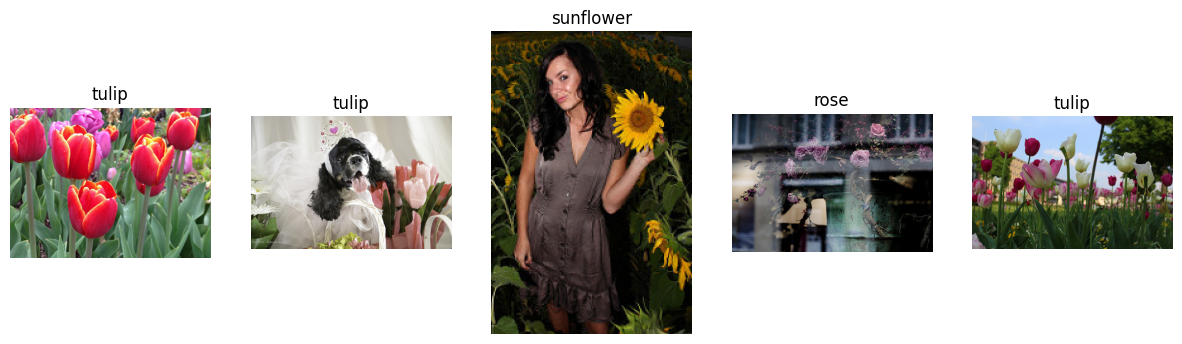

In [45]:
# Mostrar algunas imágenes aleatorias de entrenamiento
def mostrar_imagenes_aleatorias(imagenes, etiquetas, n=5):
    plt.figure(figsize=(15, 10))
    for i in range(n):
        idx = random.randint(0, len(imagenes) - 1)
        img = mpimg.imread(imagenes[idx])
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(etiquetas[idx])
        plt.axis("off")
    plt.show()

mostrar_imagenes_aleatorias(train_images, train_labels, n=5)

### 2.3 Preprocesamos las imágenes

In [46]:
import tensorflow as tf
# Definir el tamaño al que redimensionaremos las imágenes
IMG_SIZE = (224, 224)

# Función para cargar y preprocesar imágenes
def preprocess_image(image_path, label=None):
    # Leer la imagen desde el archivo
    image = tf.io.read_file(image_path)
    # Decodificar la imagen (asumimos que son JPG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensionar la imagen al tamaño deseado
    image = tf.image.resize(image, IMG_SIZE)
    # Normalizar los valores de los píxeles entre 0 y 1
    image = image / 255.0
    # Si hay una etiqueta, devolverla junto con la imagen
    if label is not None:
        return image, label
    return image

### 2.4 preprocesamos el dataset de entrenamiento y prueba

In [47]:
# Crear un diccionario para mapear las clases a números
class_names = sorted(set(train_labels))  # Obtener las clases únicas y ordenarlas
class_indices = {name: idx for idx, name in enumerate(class_names)}  # Mapear nombres a índices
print("Mapeo de clases a índices:", class_indices)

# Convertir las etiquetas de texto a números
train_labels_numeric = [class_indices[label] for label in train_labels]

# Preprocesar las imágenes de entrenamiento con etiquetas numéricas
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_numeric))
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Preprocesar las imágenes de prueba (sin etiquetas, si no las tienes)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configurar los datasets (opcional: agrupar en lotes y prefetch para mejorar el rendimiento)
BATCH_SIZE = 32
train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verificar el tamaño de las imágenes preprocesadas
for image, label in train_ds.take(1):  # Tomar un lote de entrenamiento
    print(f"Tamaño de las imágenes: {image.shape}")
    print(f"Etiquetas: {label.numpy()}")

Mapeo de clases a índices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
Tamaño de las imágenes: (32, 224, 224, 3)
Etiquetas: [4 2 0 4 4 4 3 1 0 2 3 4 0 0 2 1 3 4 1 4 1 1 1 3 0 3 4 3 4 1 1 2]


### 2.5 Definimos el modelo

In [48]:
from tensorflow.keras import layers, models

# Crear el modelo
modelo = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar y capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 clases de flores
])

from tensorflow.keras.optimizers import Adam

modelo.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar el resumen del modelo
modelo.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### 2.6 Entrenamos el modelo
#### Antes de entrenar el modelo vamos a separar train_ds y dejar el 20% de sus datos para validación, porque donde solo tenemos etiquetas es en train, las imágenes de test las usaremos mas adelante para hacer predit() y ver como se comporta en datos nuevos

In [49]:
# Separar el 20% de los datos para validación
val_size = int(len(train_images) * 0.2)

# Convertir a tensores
all_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels_numeric))
all_ds = all_ds.shuffle(len(train_images), seed=42)

# Separar en entrenamiento y validación
val_ds = all_ds.take(val_size)
train_ds = all_ds.skip(val_size)

# Preprocesar ambos
train_ds = train_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# Agrupar en lotes y optimizar
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [50]:
# Entrenar el modelo
EPOCHS = 4
historial = modelo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 357ms/step - accuracy: 0.2989 - loss: 1.5113 - val_accuracy: 0.5100 - val_loss: 1.1733
Epoch 2/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - accuracy: 0.5084 - loss: 1.1549 - val_accuracy: 0.6339 - val_loss: 1.0020
Epoch 3/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 333ms/step - accuracy: 0.5467 - loss: 1.0889 - val_accuracy: 0.6485 - val_loss: 0.9281
Epoch 4/4
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 328ms/step - accuracy: 0.6297 - loss: 0.9711 - val_accuracy: 0.6630 - val_loss: 0.9743


### 2.7 Rendimiento

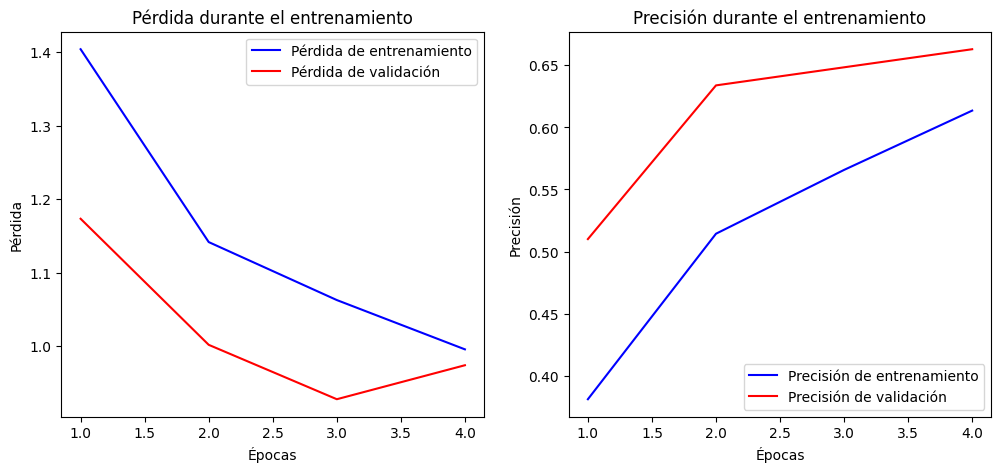

In [51]:
import matplotlib.pyplot as plt

# Graficar la pérdida y precisión
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, historial.history['loss'], 'b', label='Pérdida de entrenamiento')
plt.plot(epochs, historial.history['val_loss'], 'r', label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, historial.history['accuracy'], 'b', label='Precisión de entrenamiento')
plt.plot(epochs, historial.history['val_accuracy'], 'r', label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

### 2.8 Predicción sobre datos de prueba

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


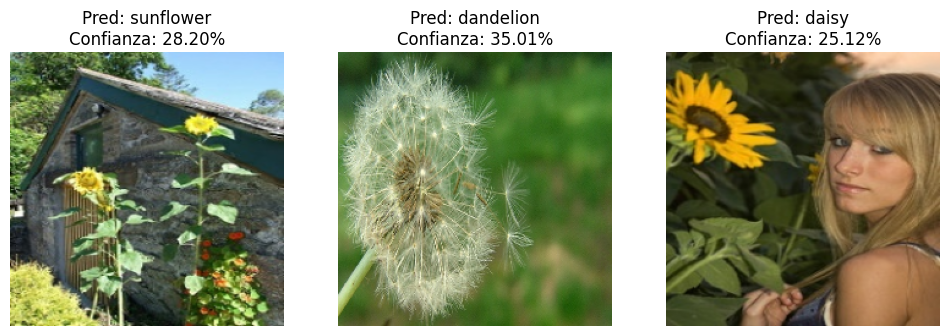

In [72]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Seleccionar 3 imágenes aleatorias de test_images
random_images = random.sample(test_images, 3)

# Mapeo de las clases a los índices (asumiendo que ya está definido)
clases = {0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

# Función para cargar y preprocesar imágenes
def preprocess_image(image_path):
    # Leer la imagen desde el archivo
    image = tf.io.read_file(image_path)
    # Decodificar la imagen (asumimos que son JPG)
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensionar la imagen al tamaño deseado
    image = tf.image.resize(image, (224, 224))
    # Normalizar los valores de los píxeles entre 0 y 1
    image = image / 255.0
    return image

# Listas para almacenar las imágenes, predicciones y confianza
imagenes = []
predicciones_muestradas = []
confianza_muestrada = []

# Preprocesar y hacer predicciones para las imágenes seleccionadas
for img_file in random_images:
    # Cargar y preprocesar la imagen
    imagen = preprocess_image(img_file)
    
    # Añadir una dimensión para el batch (1, 224, 224, 3)
    imagen = tf.expand_dims(imagen, axis=0)
    
    # Obtener la predicción para esta imagen
    prediccion = modelo.predict(imagen)  # Realizamos la predicción
    pred_clase = np.argmax(prediccion, axis=1)  # Obtener la clase predicha
    confianza = np.max(prediccion)  # Obtener la confianza de la predicción (probabilidad máxima)
    
    # Guardamos la imagen, la clase predicha y la confianza
    imagenes.append(imagen[0])  # Almacenamos la imagen sin la dimensión extra
    predicciones_muestradas.append(clases[pred_clase[0]])  # La clase predicha
    confianza_muestrada.append(confianza)  # La probabilidad de la predicción

# Verificamos si tenemos alguna imagen para mostrar
if len(imagenes) > 0:
    # Mostrar las imágenes con sus predicciones y la confianza
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, ax in enumerate(axes):
        ax.imshow(imagenes[i])
        ax.set_title(f"Pred: {predicciones_muestradas[i]}\nConfianza: {confianza_muestrada[i]*100:.2f}%")
        ax.axis('off')

    plt.show()
else:
    print("No se encontraron imágenes válidas para mostrar.")
